# Figure 2: Assess features of LADs in ESCs

In [1]:
import pandas as pd
from pybedtools import BedTool
import os
from lad_utils import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from graphviz import Digraph
import seaborn as sns

### Load Emsembl v96 gene annotations

In [2]:
# Kallisto analysis used Ensembl gene annotations v96, should do that here as well for continuity

ensembl = pd.read_csv('Homo_sapiens.GRCh38.96.gtf',
                     sep='\t', skiprows=5, header=None, 
                      names=['chrom','source','desc','start','end','score','strand','score2','desc_further'],
                     low_memory=False)
ensembl['chr'] = 'chr' + ensembl['chrom'].astype(str)
ensembl['name'] = ensembl['desc_further'].str.split('gene_name ').str[1].str.split(';').str[0].str.strip('""')

# filter for genes only

ensembl_genes = ensembl.query('desc == "gene"').copy()
n_ens_genes = pd.DataFrame(ensembl_genes['name'].value_counts())
n_ens_genes['gene'] = n_ens_genes.index
ensembl_genes_single = n_ens_genes.query('name == 1')['gene'].tolist()
ensembl_genes_single_df = ensembl_genes.query('(name in @ensembl_genes_single)').copy()

# make BED file

ens_single_bed = BedTool.from_dataframe(ensembl_genes_single_df[['chr','start','end','name']].copy()).sort()



# LB1 and H3K9me2 data

In [3]:
# this is generated by the HMM

lb1_dat = pd.read_table('LB1_HMM_predictions/LB1_dat_3state.tsv').query('cell_type == "H9ESC"').reset_index()

lb1_dat['id'] = lb1_dat.index
lb1_dat['LB1_median'] = lb1_dat[['score0','score1']].median(axis=1)
lb1_dat = assign_categories(lb1_dat, cat_names=['nonLAD','T2-LAD','T1-LAD'])
lb1_dat_bed = BedTool.from_dataframe(lb1_dat[['chrom','start','stop','id']])

h3k9me2_dat = pd.read_csv('H3K9me2_HMM_predictions/H3K9me2_dat_2state.tsv',
             sep='\t').query('cell_type == "H9ESC"').reset_index()
h3k9me2_dat['id'] = h3k9me2_dat.index
h3k9me2_dat = assign_categories(h3k9me2_dat, cat_names=['nonKDD','KDD'])
h3k9me2_dat_bed = BedTool.from_dataframe(h3k9me2_dat[['chrom','start','stop','id']])


h3k9me2_dat['H3K9me2_median'] = h3k9me2_dat[['score0','score1']].median(axis=1)

lb1_h3k9me2_merged_dat = lb1_dat.merge(h3k9me2_dat, 
                                       on=['chrom','start','stop','cell_type'], 
                                       how='inner',
                                      suffixes=('_LAD','_KDD'))

# Enrichments

In [4]:
def load_atac(f):
    return(BedTool.from_dataframe(pd.read_table(os.path.join('ATACseq',f'GSE85330/{f}'),
                                                            header=None, names=['chrom','start','end','name',
                                                                               'score','strand','score2',
                                                                               'score3','score4','score5'])[['chrom','start','end']]).sort().liftover('hg19ToHg38.over.chain.gz').sort().merge())

def get_enrichment(feature, dat):
    ors = []
    pvals = []
    cats = []

    for cat in dat['category'].unique():

        counts = np.array([[len(dat.query(f'{feature} and category == @cat')),
                  len(dat.query(f'~{feature} and category == @cat'))],
                 [len(dat.query(f'{feature} and category != @cat')),
                  len(dat.query(f'~{feature} and category != @cat'))]])

        odds, pval = stats.fisher_exact(counts)
        ors.append(odds)
        pvals.append(pval)
        cats.append(cat)

    out = pd.DataFrame({
        'odds_ratio':ors,
        'fishers_p':pvals,
        'cat':cats
    })
    
    return(out)

# Load relevant data and check which bins overlap features

In [5]:

# get overlap with genes

lb1_dat_genes = lb1_dat_bed.intersect(ens_single_bed, u=True).to_dataframe()['name'].drop_duplicates().tolist()
lb1_dat['overlaps_gene'] = lb1_dat['id'].isin(lb1_dat_genes)

# get overlap with expressed genes

exp_genes_escs = pd.read_table('RNAseq_quantile_normalized_dat.tsv').merge(ensembl_genes_single_df[['chrom','start','end','name']], left_on='gene_ID', right_on='name', how='left').query('tpm_H9ESC > 0.0')
exp_genes_escs['chr'] = 'chr' + exp_genes_escs['chrom'].astype(str)
exp_genes_escs_bed = BedTool.from_dataframe(exp_genes_escs[['chr','start','end','name','tpm_H9ESC']]).sort()
lb1_exp_genes = lb1_dat_bed.intersect(exp_genes_escs_bed, u=True).to_dataframe()['name'].drop_duplicates().tolist()
lb1_dat['overlaps_expressed_gene'] = lb1_dat['id'].isin(lb1_exp_genes)

# get overlap with ATAC peaks

h9esc_atac_peaks_rep1 = load_atac('GSM2264826_H9_0_1.filterBL.bed.gz')
h9esc_atac_peaks_rep2 = load_atac('GSM2264827_H9_0_2.filterBL.bed.gz')
h9esc_atac_peaks = h9esc_atac_peaks_rep1.intersect(h9esc_atac_peaks_rep2).sort().merge()
lb1_atac = lb1_dat_bed.intersect(h9esc_atac_peaks, u=True).to_dataframe()['name'].drop_duplicates().tolist()
lb1_dat['overlaps_atac_peak'] = lb1_dat['id'].isin(lb1_atac)

# get overlap with B compartment
h9esc_b_compartment = BedTool(os.path.join('ab_compartment_comparisons/H9ESC_B_compartment.bed')).sort()
lb1_bcomp = lb1_dat_bed.intersect(h9esc_b_compartment, u=True).to_dataframe()['name'].drop_duplicates().tolist()
lb1_dat['overlaps_B_compartment'] = lb1_dat['id'].isin(lb1_bcomp)



In [6]:
# get overlap with genes

h3k9me2_dat_genes = h3k9me2_dat_bed.intersect(ens_single_bed, u=True).to_dataframe()['name'].drop_duplicates().tolist()
h3k9me2_dat['overlaps_gene'] = h3k9me2_dat['id'].isin(h3k9me2_dat_genes)

# get overlap with expressed genes

exp_genes_escs = pd.read_table('RNAseq_quantile_normalized_dat.tsv').merge(ensembl_genes_single_df[['chrom','start','end','name']], left_on='gene_ID', right_on='name', how='left').query('tpm_H9ESC > 0.0')
exp_genes_escs['chr'] = 'chr' + exp_genes_escs['chrom'].astype(str)
exp_genes_escs_bed = BedTool.from_dataframe(exp_genes_escs[['chr','start','end','name','tpm_H9ESC']]).sort()
h3k9me2_exp_genes = h3k9me2_dat_bed.intersect(exp_genes_escs_bed, u=True).to_dataframe()['name'].drop_duplicates().tolist()
h3k9me2_dat['overlaps_expressed_gene'] = h3k9me2_dat['id'].isin(h3k9me2_exp_genes)

# get overlap with ATAC peaks

h9esc_atac_peaks_rep1 = load_atac('GSM2264826_H9_0_1.filterBL.bed.gz')
h9esc_atac_peaks_rep2 = load_atac('GSM2264827_H9_0_2.filterBL.bed.gz')
h9esc_atac_peaks = h9esc_atac_peaks_rep1.intersect(h9esc_atac_peaks_rep2).sort().merge()
h3k9me2_atac = h3k9me2_dat_bed.intersect(h9esc_atac_peaks, u=True).to_dataframe()['name'].drop_duplicates().tolist()
h3k9me2_dat['overlaps_atac_peak'] = h3k9me2_dat['id'].isin(h3k9me2_atac)

# get overlap with B compartment
h9esc_b_compartment = BedTool('ab_compartment_comparisons/H9ESC_B_compartment.bed').sort()
h3k9me2_bcomp = h3k9me2_dat_bed.intersect(h9esc_b_compartment, u=True).to_dataframe()['name'].drop_duplicates().tolist()
h3k9me2_dat['overlaps_B_compartment'] = h3k9me2_dat['id'].isin(h3k9me2_bcomp)

# Calculate ORs and p-values

In [7]:
gene_enrichment = get_enrichment('overlaps_gene', lb1_dat)
gene_enrichment['enr_type'] = 'gene'

expressed_gene_enrichment = get_enrichment('overlaps_expressed_gene', lb1_dat)
expressed_gene_enrichment['enr_type'] = 'exp_gene'

atac_gene_enrichment = get_enrichment('overlaps_atac_peak', lb1_dat)
atac_gene_enrichment['enr_type'] = 'atac'

bcomp_gene_enrichment = get_enrichment('overlaps_B_compartment', lb1_dat)
bcomp_gene_enrichment['enr_type'] = 'bcomp'

enrichment_all = pd.concat([gene_enrichment, 
                            expressed_gene_enrichment, 
                            atac_gene_enrichment,
                            bcomp_gene_enrichment], sort=False)

enrichment_all['neg_log10_p'] = -enrichment_all['fishers_p'].map(np.log10)
enrichment_all = enrichment_all.replace(np.inf, 300)

/pollard/home/kathleen/miniconda3/envs/LAD_analysis/lib/python3.7/site-packages/pandas/core/base.py:1300: RuntimeWarning: divide by zero encountered in log10
  new_values = map_f(values, mapper)


In [8]:
gene_enrichment_h3k9me2 = get_enrichment('overlaps_gene', h3k9me2_dat)
gene_enrichment_h3k9me2['enr_type'] = 'gene'

expressed_gene_enrichment_h3k9me2 = get_enrichment('overlaps_expressed_gene', h3k9me2_dat)
expressed_gene_enrichment_h3k9me2['enr_type'] = 'exp_gene'

atac_enrichment_h3k9me2 = get_enrichment('overlaps_atac_peak', h3k9me2_dat)
atac_enrichment_h3k9me2['enr_type'] = 'atac'

bcomp_enrichment_h3k9me2 = get_enrichment('overlaps_B_compartment', h3k9me2_dat)
bcomp_enrichment_h3k9me2['enr_type'] = 'bcomp'

enrichment_h3k9me2_all = pd.concat([gene_enrichment_h3k9me2, 
                            expressed_gene_enrichment_h3k9me2, 
                            atac_enrichment_h3k9me2,
                            bcomp_enrichment_h3k9me2], sort=False)

enrichment_h3k9me2_all['neg_log10_p'] = -enrichment_h3k9me2_all['fishers_p'].map(np.log10)
enrichment_h3k9me2_all = enrichment_h3k9me2_all.replace(np.inf, 300)

# overall figure

# LADs only

### add HMM figure

In [9]:
with open('LB1_trained_HMMs/3_state_LAD_HMM_renamed.json') as json_f:
    data = json.load(json_f)
    

# Create Digraph object
dot = Digraph(engine='dot')

# Add nodes

dot.attr('node', penwidth='2.5', fontname='Helvetica', fontstyle='14')
dot.node('Start')
dot.attr('node', color='#de8f05')
dot.node('T1-LAD')
dot.attr('node', color='#029e73')
dot.node('T2-LAD')
dot.attr('node', color='#0173b2')
dot.node('nonLAD')

# Add edges

dot.attr('edge', penwidth='2.5', fontname='Helvetica', fontstyle='14')

dot.edge('Start','T1-LAD', label='0.28')
dot.edge('Start','T2-LAD', label='0.61')
dot.edge('Start','nonLAD', label='0.11')

dot.edge('T1-LAD','nonLAD', label='0.00021')
dot.edge('T1-LAD','T2-LAD', label='0.020')

dot.edge('T2-LAD','nonLAD', label='0.045')
dot.edge('T2-LAD','T1-LAD', label='0.050')

dot.edge('T1-LAD','T1-LAD', label='0.98')
dot.edge('T2-LAD','T2-LAD', label='0.91')
dot.edge('nonLAD','nonLAD', label='0.97')

# Visualize the graph
dot.attr('graph',dpi='1000')

dot.render('lad_hmm', format='png', view=True)


'lad_hmm.png'

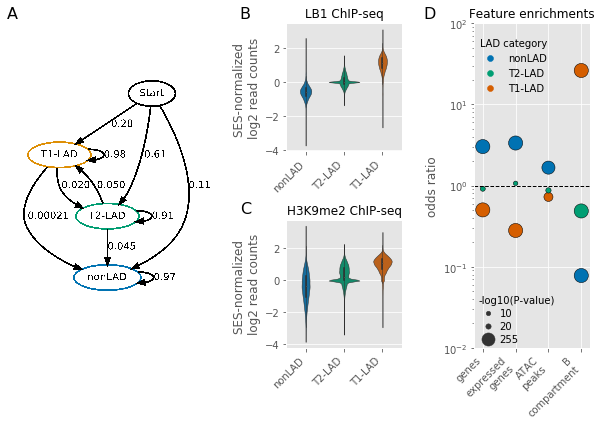

In [9]:
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')

fig = plt.figure(figsize=(8.5,6))

plt.subplots_adjust(hspace=1.1, wspace=0.7)

gs = mpl.gridspec.GridSpec(2, 3, width_ratios=[1,0.6, 0.6],
                          height_ratios=[1,1])

# linewidth

lw=0.5
label_pad = 0.05

# panel A: LAD HMM

axA = plt.subplot(gs[0:2,0])

# changed the names in the json file and this worked fine


img = mpl.image.imread('lad_hmm.png')

axA.imshow(img)

axA.xaxis.set_visible(False)
axA.yaxis.set_visible(False)

axA.margins(0.0)

# panel B: LB1 in LADs

axB = plt.subplot(gs[0,1])

sns.violinplot(x='category', y='LB1_median', 
               data=lb1_dat.query('cell_type == "H9ESC"').replace(lad_replace),
              ax=axB, order=['nonLAD','T2-LAD','T1-LAD'], linewidth=lw)

axB.set(ylabel='SES-normalized \nlog2 read counts', xlabel=None, 
        title='LB1 ChIP-seq')

# panel C: H3K9me2 in LADs

axC = plt.subplot(gs[1,1])

sns.violinplot(x='category_LAD', y='H3K9me2_median', 
               data=lb1_h3k9me2_merged_dat.query('cell_type == "H9ESC"').replace(lad_replace),
              ax=axC, order=['nonLAD','T2-LAD','T1-LAD'], linewidth=lw)

axC.set(ylabel='SES-normalized \nlog2 read counts', xlabel=None, 
        title='H3K9me2 ChIP-seq')

# panel D: enrichments

axD = plt.subplot(gs[0:2,2])

sns.scatterplot(x='enr_type', y='odds_ratio', 
                data=enrichment_all.replace(lad_replace).replace({
                    'gene':'genes',
                    'exp_gene':'expressed\ngenes',
                    'atac':'ATAC\npeaks',
                    'bcomp':'B\ncompartment'}),
                size='neg_log10_p', 
                hue_order=['nonLAD','T2-LAD','T1-LAD'], 
                hue='cat', sizes=(20,200),
                ax=axD, linewidth=lw, edgecolor='black')

handles, labels = axD.get_legend_handles_labels()
size_handles = handles[5:]
sizes_handles = size_handles[::2]
size_labels = labels[5:]
sizes_labels = [ str(int(5*round(float(x)/5,0))) for x in size_labels[::2] ]

leg = axD.legend(sizes_handles, sizes_labels, frameon=False,
          title='-log10(P-value)', loc='lower left',
          borderaxespad=0., handletextpad=0.1, labelspacing=0.3)

leg._legend_box.align='left'

axD.axhline(1, linestyle='dashed', color='black', linewidth=2*lw)

axD.set(ylabel='odds ratio', xlabel=None,
       title='Feature enrichments', yscale='log',
       ylim=(0.01, 100))

lines, labels = axD.get_legend_handles_labels()
lines = lines[1:4]
labels = labels[1:4]
fig.legend(lines, labels, loc = (0.79, 0.77),
           frameon=False, title='LAD category')

# set fontsizes and add panel labels

for ax in [axB, axC, axD]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(12)
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(10)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')

fig.text(0.0, 0.95, 'A', fontsize=16,
         ha='left')
fig.text(0.38, 0.95, 'B', fontsize=16,
         ha='left')
fig.text(0.38, 0.5, 'C', fontsize=16,
         ha='left')
fig.text(0.68, 0.95, 'D', fontsize=16,
         ha='left')
    
plt.tight_layout()

# fig.savefig(os.path.join('../figs/Fig2_characteristics_LADs_low_res.png'),
#            dpi=100, bbox_inches='tight')

# fig.savefig(os.path.join(fig_path,'Fig2_characteristics_LADs.pdf'),
#            dpi=300, bbox_inches='tight')

# KDD figure

In [11]:
with open('H3K9me2_trained_HMMs/2_state_H3K9me2_HMM_renamed.json') as json_f:
    data = json.load(json_f)

In [12]:
from graphviz import Digraph

# Create Digraph object
dot = Digraph(engine='dot')

# Add nodes

dot.attr('node', penwidth='2.5', fontname='Helvetica', fontstyle='14')
dot.node('Start')
dot.attr('node', color='#029e73')
dot.node('KDD')
dot.attr('node', color='#0173b2')
dot.node('nonKDD')

# Add edges

dot.attr('edge', penwidth='2.5', fontname='Helvetica', fontstyle='14')

dot.edge('Start','KDD', label='0.63')
dot.edge('Start','nonKDD', label='0.37')

dot.edge('KDD','nonKDD', label='0.00025')

dot.edge('KDD','KDD', label='0.99')

dot.edge('nonKDD','nonKDD', label='0.99')

# Visualize the graph
dot.attr('graph',dpi='1000')

dot.render('kdd_hmm', format='png', view=True)


'kdd_hmm.png'

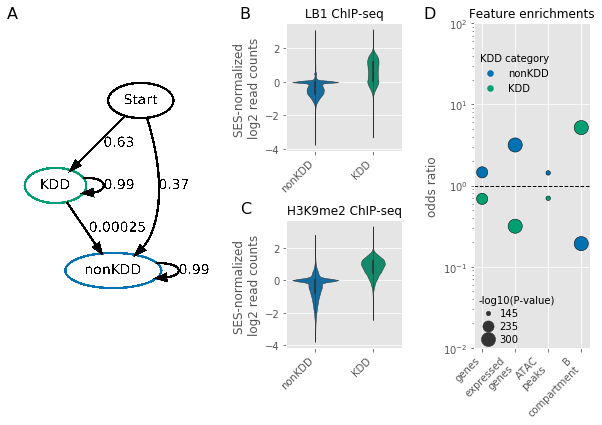

In [28]:
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')

fig = plt.figure(figsize=(8.5,6))

plt.subplots_adjust(hspace=1.1, wspace=0.7)

gs = mpl.gridspec.GridSpec(2, 3, width_ratios=[1,0.6, 0.6],
                          height_ratios=[1,1])

# linewidth
lw=0.5
label_pad = 0.05

# panel A: KDD HMM

axA = plt.subplot(gs[0:2,0])

img = mpl.image.imread('kdd_hmm.png')

axA.imshow(img)

axA.xaxis.set_visible(False)
axA.yaxis.set_visible(False)

axA.margins(0.0)

# panel B: LB1 in KDDs

axB = plt.subplot(gs[0,1])

sns.violinplot(x='category_KDD', y='LB1_median', 
               data=lb1_h3k9me2_merged_dat.query('cell_type == "H9ESC"').replace(kdd_replace),
              ax=axB, order=['nonKDD','KDD'], linewidth=lw)

axB.set(ylabel='SES-normalized \nlog2 read counts', xlabel=None, 
        title='LB1 ChIP-seq')

# panel C: H3K9me2 in KDDs

axC = plt.subplot(gs[1,1])

sns.violinplot(x='category', y='H3K9me2_median', 
               data=h3k9me2_dat.query('cell_type == "H9ESC"').replace(kdd_replace),
              ax=axC, order=['nonKDD','KDD'], linewidth=lw)

axC.set(ylabel='SES-normalized \nlog2 read counts', xlabel=None, 
        title='H3K9me2 ChIP-seq')

# panel D: enrichments

axD = plt.subplot(gs[0:2,2])

sns.scatterplot(x='enr_type', y='odds_ratio', 
                data=enrichment_h3k9me2_all.replace(kdd_replace).replace({
                    'gene':'genes',
                    'exp_gene':'expressed\ngenes',
                    'atac':'ATAC\npeaks',
                    'bcomp':'B\ncompartment'}),
                size='neg_log10_p', 
                hue_order=['nonKDD','KDD'], 
                hue='cat', sizes=(20, 200),
                ax=axD, linewidth=lw, edgecolor='black')

handles, labels = axD.get_legend_handles_labels()
size_handles = handles[4:]
sizes_handles = size_handles
size_labels = labels[4:]
sizes_labels = [ str(int(5*round(float(x)/5,0))) for x in size_labels ]

leg = axD.legend(sizes_handles, sizes_labels, frameon=False,
          title='-log10(P-value)', loc='lower left',
          borderaxespad=0., handletextpad=0.1, labelspacing=0.3)

leg._legend_box.align='left'

axD.axhline(1, linestyle='dashed', color='black', linewidth=2*lw)

axD.set(ylabel='odds ratio', xlabel=None,
       title='Feature enrichments', yscale='log',
       ylim=(0.01, 100))

lines, labels = axD.get_legend_handles_labels()
lines = lines[1:3]
labels = labels[1:3]
fig.legend(lines, labels, loc = (0.79, 0.77),
           frameon=False, title='KDD category')

# set fontsizes and add panel labels

for ax in [axB, axC, axD]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(12)
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(10)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')

fig.text(0.0, 0.95, 'A', fontsize=16,
         ha='left')
fig.text(0.38, 0.95, 'B', fontsize=16,
         ha='left')
fig.text(0.38, 0.5, 'C', fontsize=16,
         ha='left')
fig.text(0.68, 0.95, 'D', fontsize=16,
         ha='left')
    
plt.tight_layout()

# fig.savefig(os.path.join(fig_path,'Fig4_characteristics_KDDs_rr_option.png'),
#            dpi=300, bbox_inches='tight')

fig.savefig('../figs/Fig4_characteristics_KDDs_rr_option_low_res.png',
           dpi=100, bbox_inches='tight')

# fig.savefig(os.path.join(fig_path,'Fig4_characteristics_KDDs.pdf'),
#            dpi=300, bbox_inches='tight')